#**Neural Style Transfer**

### Mount google drive so that you have acccess to utility scripts

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/py_utils/*.* /content

### Load Tensorflow ver 1.x and other packages

In [0]:
%tensorflow_version 1.x

In [4]:
from utils import imread, imresize, imsave, fromimage, toimage

from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import time
import os

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
#from keras.utils.layer_utils import convert_all_kernels_in_model

Using TensorFlow backend.


### Set hyperparameters 

In [0]:
num_iterations = 100
rescale_image = False
maintain_aspect_ratio = True
min_improvement = 0.0
prev_min_val = -1
pooltype = 1 
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
MODEL = "vgg19"
content_loss_type = 0
content_layer = 'conv5_2'
content_weight = 1.0
style_weights = 0.01
total_variation_weight = 8.5e-05

### Load content and style images

In [0]:
base_image_path = '/content/drive/My Drive/content/content_pic.png'
style_path = '/content/drive/My Drive/style/Style_pic.png'

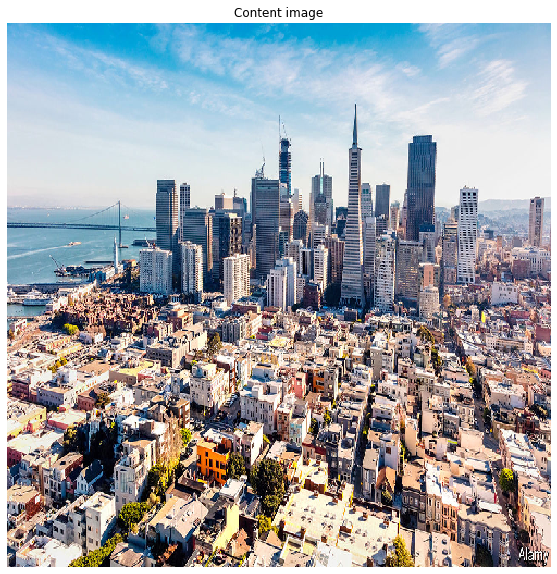

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
content_img = plt.imread(base_image_path)
plt.axis('off')
plt.title('Content image')
plt.imshow(content_img)

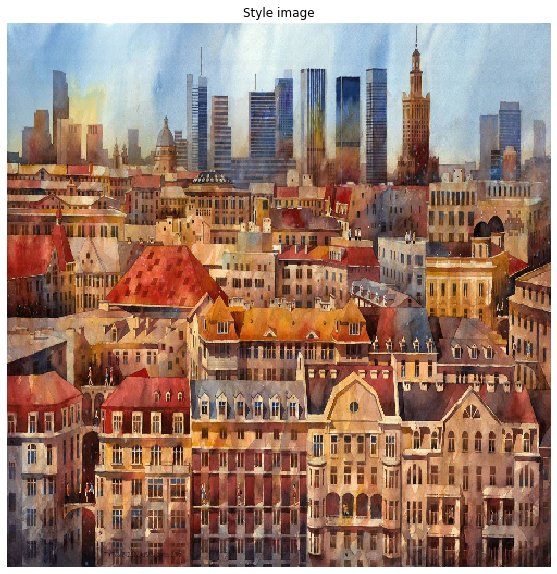

In [8]:
fig = plt.figure(figsize=(10, 10))
style_img = plt.imread(style_path)
plt.axis('off')
plt.title('Style image')
plt.imshow(style_img)

### Utility to preprocess images as per VGG preprocessing

In [0]:
# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path, load_dims=False, mode="RGB"):
    global img_width, img_height, aspect_ratio

    img = imread(image_path, mode=mode)  # Prevents crashes due to PNG images (ARGB)

    if load_dims:
        img_width = img.shape[0]
        img_height = img.shape[1]
        aspect_ratio = float(img_height) / img_width

        if maintain_aspect_ratio:
            img_height = int(img_width * aspect_ratio)
        else:
            img_height = img_width

    img = imresize(img, (img_width, img_height)).astype('float32')

    # RGB -> BGR
    img = img[:, :, ::-1]

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    img = np.expand_dims(img, axis=0)
    return img

In [0]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.reshape((img_width, img_height, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Constructing the input tensor to the model

In [0]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path, True))

In [0]:
style_image_tensor = K.variable(preprocess_image(style_path))

In [13]:
# this will contain our generated image
combination_image = K.placeholder((1, img_width, img_height, 3))

In [0]:
image_tensors = [base_image]
image_tensors.append(style_image_tensor)
image_tensors.append(combination_image)

In [0]:
# combine the various images into a single Keras tensor
input_tensor = K.concatenate(image_tensors, axis=0)

### Model definition

In [0]:
def pooling_func(x):
    if pooltype == 1:
        return AveragePooling2D((2, 2), strides=(2, 2))(x)
    else:
        return MaxPooling2D((2, 2), strides=(2, 2))(x)

In [0]:
def new_vgg(input_tensor, shape):

  ip = Input(tensor=input_tensor, batch_shape=shape)

  # build the VGG16 network with our 3 images as input
  x = Convolution2D(64, (3, 3), activation='relu', name='conv1_1', padding='same')(ip)
  x = Convolution2D(64, (3, 3), activation='relu', name='conv1_2', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(128, (3, 3), activation='relu', name='conv2_1', padding='same')(x)
  x = Convolution2D(128, (3, 3), activation='relu', name='conv2_2', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(256, (3, 3), activation='relu', name='conv3_1', padding='same')(x)
  x = Convolution2D(256, (3, 3), activation='relu', name='conv3_2', padding='same')(x)
  x = Convolution2D(256, (3, 3), activation='relu', name='conv3_3', padding='same')(x)
  if MODEL == "vgg19":
      x = Convolution2D(256, (3, 3), activation='relu', name='conv3_4', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(512, (3, 3), activation='relu', name='conv4_1', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv4_2', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv4_3', padding='same')(x)
  if MODEL == "vgg19":
      x = Convolution2D(512, (3, 3), activation='relu', name='conv4_4', padding='same')(x)
  x = pooling_func(x)

  x = Convolution2D(512, (3, 3), activation='relu', name='conv5_1', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv5_2', padding='same')(x)
  x = Convolution2D(512, (3, 3), activation='relu', name='conv5_3', padding='same')(x)
  if MODEL == "vgg19":
      x = Convolution2D(512, (3, 3), activation='relu', name='conv5_4', padding='same')(x)
  x = pooling_func(x)
  model = Model(ip, x)
  if MODEL == "vgg19":
    weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_19_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  else:
    weights = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', TF_WEIGHTS_PATH_NO_TOP, cache_subdir='models')
  model.load_weights(weights)

  # get the symbolic outputs of each "key" layer (we gave them unique names)
  outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
  shape_dict = dict([(layer.name, layer.output_shape) for layer in model.layers])

  return model, outputs_dict, shape_dict

In [18]:
shape = (len(image_tensors), img_width, img_height, 3); shape

(3, 500, 500, 3)

In [19]:
model, outputs_dict, shape_dict = new_vgg(input_tensor, shape)




80142336/80134624 [==============================] - 1s 0us/step








In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 500, 500, 3)          0         
_________________________________________________________________
conv1_1 (Conv2D)             (3, 500, 500, 64)         1792      
_________________________________________________________________
conv1_2 (Conv2D)             (3, 500, 500, 64)         36928     
_________________________________________________________________
average_pooling2d_1 (Average (3, 250, 250, 64)         0         
_________________________________________________________________
conv2_1 (Conv2D)             (3, 250, 250, 128)        73856     
_________________________________________________________________
conv2_2 (Conv2D)             (3, 250, 250, 128)        147584    
_________________________________________________________________
average_pooling2d_2 (Average (3, 125, 125, 128)        0   

In [0]:
if MODEL == "vgg19":
    feature_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv3_4',
                      'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2', 'conv5_3', 'conv5_4']
else:
    feature_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3',
                      'conv4_1', 'conv4_2', 'conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

## Defining the various loss items

In [0]:
# the gram matrix of an image tensor (feature-wise outer product) using shifted activations
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features-1, K.transpose(features-1))    
    return gram

In [0]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss_func(style, combination):
    
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_width * img_height
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
# computing style loss across layers with geometric style weighting
nb_layers = len(feature_layers) - 1
style_loss = K.variable(0.)
for i in range(nb_layers):
    layer_features = outputs_dict[feature_layers[i]]
    combination_features = layer_features[2, :, :, :]
    style_reference_features = layer_features[1, :, :, :]
    sl = style_loss_func(style_reference_features, combination_features)
    style_loss = style_loss + (style_weights / (2 ** (nb_layers - (i + 1)))) * sl


In [25]:
print(len(feature_layers))

16


In [0]:
# content loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss_func(base, combination):
    size = img_width * img_height

    if content_loss_type == 1:
        multiplier = 1. / (2. * (channels ** 0.5) * (size ** 0.5))
    elif content_loss_type == 2:
        multiplier = 1. / (channels * size)
    else:
        multiplier = 1.

    return multiplier * K.sum(K.square(combination - base))

In [0]:
layer_features = outputs_dict[content_layer]
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
content_loss = content_weight * content_loss_func(base_image_features,
                                      combination_features)

In [0]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = K.square(x[:, :img_width - 1, :img_height - 1, :] - x[:, 1:, :img_height - 1, :])
    b = K.square(x[:, :img_width - 1, :img_height - 1, :] - x[:, :img_width - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
var_loss = total_variation_weight * total_variation_loss(combination_image)

In [0]:
loss = content_loss + style_loss + var_loss

### The loss function is being minimized using the fmin_l_bfgs_b (Broyden–Fletcher–Goldfarb–Shanno) optimizer with limited memory. This requires the gradients and loss value to be separately available

In [31]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
outputs = [loss]
outputs += grads
f_outputs = K.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_width, img_height, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator = Evaluator()

## Choose the initial image. We can choose a randomly generated noise or the content image

In [0]:
#x = preprocess_image(base_image_path, True)
x = np.random.uniform(0, 255, (1, img_width, img_height, 3)) - 128.

In [37]:
x.shape

(1, 500, 500, 3)

## Training the model

In [0]:
# create a directory for generated images and also nomenclature for each iteration of generated image

result_dir = "generated/"
result_prefix = result_dir + "gen"
final_image_path = result_prefix + "_at_iteration_%d.png" % (num_iterations)

if not os.path.exists(result_dir):
  os.makedirs(result_dir)

In [0]:
def train_model(x, prev_min_val=prev_min_val):
  improvement_threshold = float(min_improvement)
  for i in range(num_iterations):
    print("Starting iteration %d of %d" % ((i + 1), num_iterations))
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)

    if prev_min_val == -1:
        prev_min_val = min_val

    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print("Current loss value:", min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
    # save current generated image
    img = deprocess_image(x.copy())

    img_ht = int(img_width * aspect_ratio)
    print("Rescaling Image to (%d, %d)" % (img_width, img_ht))
    img = imresize(img, (img_width, img_ht), interp='bilinear')
        

    fname = result_prefix + "_at_iteration_%d.png" % (i + 1)
    imsave(fname, img)
    end_time = time.time()
    print("Image saved as", fname)
    print("Iteration %d completed in %ds" % (i + 1, end_time - start_time))

    if improvement_threshold is not 0.0:
        if improvement < improvement_threshold and improvement is not 0.0:
            print("Improvement (%f) is less than improvement threshold (%f). Early stopping script." %
                  (improvement, improvement_threshold))
            exit()

In [40]:
train_model(x)

Starting iteration 1 of 100
Current loss value: 30467070.0  Improvement : 0.000 %
Rescaling Image to (500, 500)
Image saved as generated/gen_at_iteration_1.png
Iteration 1 completed in 13s
Starting iteration 2 of 100
Current loss value: 15335782.0  Improvement : 49.664 %
Rescaling Image to (500, 500)
Image saved as generated/gen_at_iteration_2.png
Iteration 2 completed in 5s
Starting iteration 3 of 100
Current loss value: 10067738.0  Improvement : 34.351 %
Rescaling Image to (500, 500)
Image saved as generated/gen_at_iteration_3.png
Iteration 3 completed in 5s
Starting iteration 4 of 100
Current loss value: 7499371.5  Improvement : 25.511 %
Rescaling Image to (500, 500)
Image saved as generated/gen_at_iteration_4.png
Iteration 4 completed in 5s
Starting iteration 5 of 100
Current loss value: 6137052.0  Improvement : 18.166 %
Rescaling Image to (500, 500)
Image saved as generated/gen_at_iteration_5.png
Iteration 5 completed in 5s
Starting iteration 6 of 100
Current loss value: 5314634.5

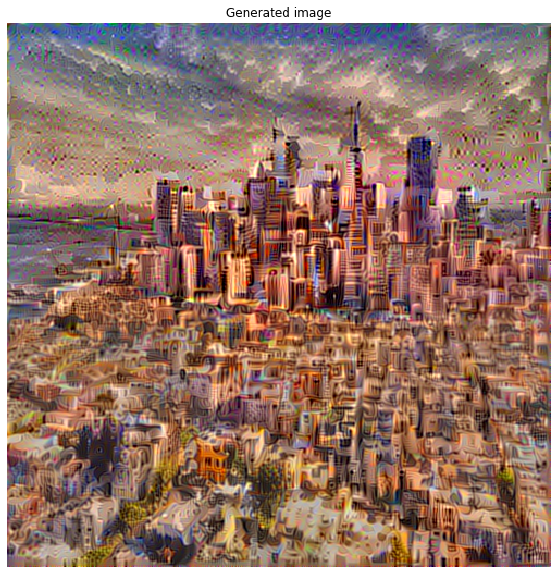

In [41]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(final_image_path)
plt.axis('off')
plt.title('Generated image')
plt.imshow(img)